# Informe Técnico 
# Supply Marketplace Analyst Challenge

### _Luis Muñiz Valledor_




## Carga de datos y librerías necesarias

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Se establece el tipo de dato durante la carga
tipos = {
    'id': 'int',  # Identificador
    'parent_id': 'str',  # ID del padre
    'is_complex': 'int',  # Indicador binario (1 o 0)
    'square_space': 'float',  # Espacio en metros cuadrados
    'spot_type_id': 'str',  # Tipo de spot
    'currency_type': 'str',  # Tipo de moneda
    'modality': 'str',  # Modalidad
    'latitude': 'float',  # Latitud
    'longitude': 'float',  # Longitud
    'rate': 'float',  # Tarifa
    'created_at': 'str'  # Fecha de creación, como string para luego convertirlo a datetime si es necesario
}

data = pd.read_csv('Supply_MarketPlace_Analyst_Challenge_DATA.csv', dtype=tipos)
geo_data = gpd.read_file('Corredor_Polanco.geojson')

## Análisis exploratorio

Se muestran algunos datos iniciales del dataframe

In [3]:
print(data.head(10))

      id parent_id  is_complex  square_space spot_type_id currency_type  \
0  14241       NaN           1       19000.0            9             1   
1  14241       NaN           1       19000.0            9             1   
2  14584       NaN           0        1200.0            9             1   
3  14585       NaN           0        4000.0            9             1   
4  14595       NaN           0        2000.0            9             1   
5  14636       NaN           0      140000.0           15             2   
6  14639       NaN           0         374.0           13             1   
7  14640       NaN           1         325.0           11             1   
8  14641       NaN           1         325.0           11             1   
9  14643       NaN           0          20.0           13             1   

  modality   latitude   longitude        rate            created_at  
0        2  19.458583  -99.198380    150000.0  2023-08-17T16:25:02Z  
1        1  19.458583  -99.198380 

### Tratamiento de datos faltantes y atípicos

Se identifican las variables con valores faltantes

In [4]:
print(data.isnull().sum())

id                  0
parent_id        2588
is_complex          0
square_space        0
spot_type_id     1760
currency_type      35
modality           35
latitude         1760
longitude        1760
rate               35
created_at          0
dtype: int64


Se espera (por las consideraciones del documento *Supply Marketplace Analyst Challenge*) que la variable `parent_id` presente valors faltantes. No considero conveniente realizar técnicas avanzadas de tratamiento de datos faltantes tales como imputación de datos. Esto se debe a que esta técnica requiere de conocimiento adicional (tanto en el enfoque bayesiano como en el clásico de la estadística). Según convenga, se deberá optar por la supresión de los registros o por establecer una categoría para los valores faltantes, esto permitiría realizar un análisis por grupo. Por ejemplo, la variable `spot_type_id` tiene muchos registros con valores faltantes. En este caso, no conviene eliminarlos, sino considerarlos como un tipo de establecimiento "tipo-no-stablecedo".

In [5]:
data['spot_type_id'] = data['spot_type_id'].fillna('faltante')

Se verifica que los registros con valores faltantes en las variables `currency_type`, `modality` y `rate` son los mismos.

In [6]:
print(data[data['rate'].notnull()].isnull().sum())

id                  0
parent_id        2578
is_complex          0
square_space        0
spot_type_id        0
currency_type       0
modality            0
latitude         1735
longitude        1735
rate                0
created_at          0
dtype: int64


Ya que los registros afectados son pocos (35) y que no hay información suficiente para reconstruirlos, lo mas conveniente será eliminarlos al realizar los cálculos.

Se crea una nueva tabla sin estos registros. En lo que sigue, se usará una u otra según convenga.

In [7]:
data2 = data[data['rate'].notnull()].copy()

Veamos algunos estadísticos de las variables `rate` y `square_space`.

In [8]:
print(data2[['rate', 'square_space']].describe())

               rate  square_space
count  4.541000e+03  4.541000e+03
mean   3.760917e+06  8.339730e+03
std    2.715757e+07  7.350904e+04
min    1.000000e+00  1.000000e+00
25%    3.000000e+02  1.510000e+02
50%    6.500000e+03  5.800000e+02
75%    7.500000e+04  2.200000e+03
max    1.172250e+09  3.610000e+06


Se observa que esta variable toman valores en varios órdenes de magnitud, lo que sugiere que es recomendable realizar un cambio de escala (por ejemplo una escala logarítmica). Además, estas variables llegan a tomar valores muy bajos 1.0. No imagino la venta o renta de un local por un peso o por un dólar. Tampoco imagino locales de un metro cuadrado. Esto sugiere que se deben filtrar los valores menores a cierto umbral (el cual desconozco) ya que deben ser valors erróneos. Además, un local de 3.610000e+06 metros cuadrados me parece improbable. No tengo idea de cual debe ser el umbral máximo para el área y para el precio, pero podemos tomar algún criterio estadístico para establecerlo.

Se crea una nueva variable con los valores de rate en pesos mexicanos para todos los registros

In [9]:
tipo_cambio_usd_a_mxn = 17 #Se puede mejorar, conectándose mediante una API para obtener el tipo de cambio actual.

def convertir_a_mxn(row, tipo_cambio):
    if row['currency_type'] == "1":  # Si la moneda ya está en MXN
        return row['rate']
    elif row['currency_type'] == "2":  # Si la moneda está en USD
        return row['rate'] * tipo_cambio
    else:
        return None  # Para casos donde 'currency_type' no es ni 1 ni 2, por si hay datos erróneos

# Aplicar la función y asignar los valores a la nueva columna utilizando .loc
data2.loc[:, 'rate_mxn'] = data2.apply(lambda row: convertir_a_mxn(row, tipo_cambio_usd_a_mxn), axis=1)

Se crean variables en escala logarítmica

In [10]:
data2['rate_log'] = np.log10(data2['rate'])
data2['rate_mxn_log'] = np.log10(data2['rate_mxn'])
data2['square_space_log'] = np.log10(data2['square_space'])

Un criterio para identificar valores atípicos podría ser detectar los puntos fuera de los bigotes de un boxplot

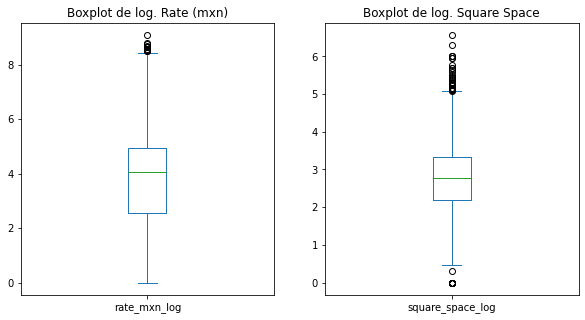

In [11]:
# Creando los boxplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data2['rate_mxn_log'].plot(kind='box')
plt.title('Boxplot de log. Rate (mxn)')

plt.subplot(1, 2, 2)
data2['square_space_log'].plot(kind='box')
plt.title('Boxplot de log. Square Space')

plt.show()

Podemos filtrar (aproximadamente) estos valores mediante:

In [12]:
Q1_r = data2['rate_mxn_log'].quantile(0.25)
Q3_r = data2['rate_mxn_log'].quantile(0.75)

Q1_s = data2['square_space_log'].quantile(0.25)
Q3_s = data2['square_space_log'].quantile(0.75)

IQR_r = Q3_r - Q1_r # Se obtiene el rango intercuatílico rate_mxn_log
IQR_s = Q3_s - Q1_s # Se obtiene el rango intercuatílico square_space_log

# Límite de los bigotes del boxplot
limite_inferior_r = Q1_r - 1.5 * IQR_r
limite_superior_r = Q3_r + 1.5 * IQR_r

limite_inferior_s = Q1_s - 1.5 * IQR_s
limite_superior_s = Q3_s + 1.5 * IQR_s

# Filtrar los datos atípicos
datos_atipicos = data2[(data2['rate_mxn_log'] < limite_inferior_r) | (data2['rate_mxn_log'] > limite_superior_r) | (data2['square_space_log'] < limite_inferior_s) | (data2['square_space_log'] > limite_superior_s)]


# Filtrar los datos que no son atípicos
data3 = data2[(data2['rate_mxn_log'] >= limite_inferior_r) & (data2['rate_mxn_log'] <= limite_superior_r) & (data2['square_space_log'] >= limite_inferior_s) & (data2['square_space_log'] <= limite_superior_s)].copy()

Se observa, que ahora el dataframe `datos_no_atipicos` no presenta (salvo alguna imprecision en el límite del bigote que se puede deber a alguna pequeña diferencia del algoritmo del boxplot) estos datos atípicos.

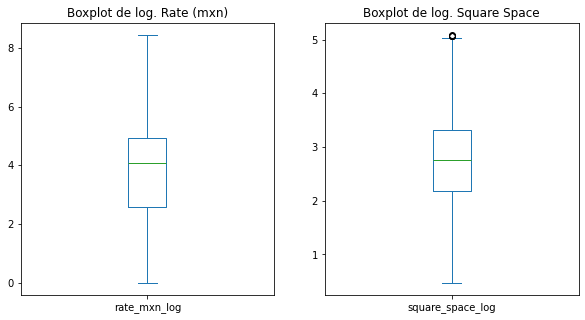

In [13]:
# Creando los boxplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data3['rate_mxn_log'].plot(kind='box')
plt.title('Boxplot de log. Rate (mxn)')

plt.subplot(1, 2, 2)
data3['square_space_log'].plot(kind='box')
plt.title('Boxplot de log. Square Space')

plt.show()

Esta solución ha sido una improvisación y puede que no sea la adecuada en la práctica, pero es una buena solución si no se cuenta con información adicional (del sector inmobiliario) que establezca debidamente estos umbrales.

Por otra parte, el detectar los valores atípicos de cada variable por separado no garantiza que no existan valores atípicos al hacer un análisis multivariado, ya que los puntos atípicos podrían estar en el producto cartesiano del conjunto de valores que toman ambas variables. Para esto, se deben aplicar otras técnicas, pero para no extenderme más en este apartado daré por bueno este análisis.

### Valor promedio por metro cuadrado

La siguiente tabla resume el valor promedio por metro cuadrado para cada tipo de spot y modalidad

In [14]:
# Calcula el valor por metro cuadrado
data3['value_per_sqm'] = data3['rate'] / data3['square_space']
data3['value_per_sqm_mxn'] = data3['rate_mxn'] / data3['square_space']

# Agrupa y calcula la media
average_values = data3.groupby(['spot_type_id', 'modality'])['value_per_sqm_mxn'].mean()
print(average_values)

spot_type_id  modality
11            1             263.612581
              2           23663.730308
13            1             958.227634
              2           32933.153037
15            1              90.749790
              2            9100.801706
9             1              52.640502
              2           10988.656376
faltante      1              27.644694
              2            1958.259052
Name: value_per_sqm_mxn, dtype: float64


In [15]:
average_values_df = average_values.reset_index()

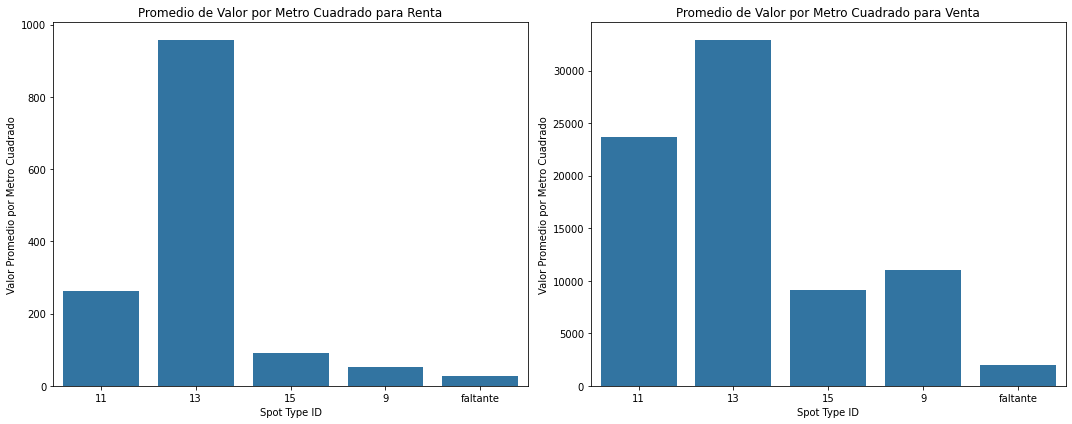

In [16]:
modalidad_1 = average_values_df[average_values_df['modality'] == "1"]
modalidad_2 = average_values_df[average_values_df['modality'] == "2"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Gráfico para la Modalidad 1 (Renta)
sns.barplot(x='spot_type_id', y='value_per_sqm_mxn', data=modalidad_1, ax=axes[0])
axes[0].set_title('Promedio de Valor por Metro Cuadrado para Renta')
axes[0].set_xlabel('Spot Type ID')
axes[0].set_ylabel('Valor Promedio por Metro Cuadrado')

# Gráfico para la Modalidad 2 (Venta)
sns.barplot(x='spot_type_id', y='value_per_sqm_mxn', data=modalidad_2, ax=axes[1])
axes[1].set_title('Promedio de Valor por Metro Cuadrado para Venta')
axes[1].set_xlabel('Spot Type ID')
axes[1].set_ylabel('Valor Promedio por Metro Cuadrado')

plt.tight_layout()
plt.show()

Como se puede apreciar, se obtienen los promedios también para los establecimientos sin tipo. Esto podría ser de interés práctico. Se observa que los establecimientos Retail son los más valorados (de media) por metro cuadrado, tanto en venta como en renta seguido de las oficinas. Mientras que los menos valorados son los que no tienen un tipo asignado (tanto en renta como en venta).  

### Análisis geoespacial 

In [17]:
# Se filtran los Retail en Renta
espacios_retail_renta = data3[(data3['spot_type_id'] == '13') & (data3['modality'] == '1')].copy()

In [18]:
# Se crean los puntos con latitude y longitude y se almacenan en la variable geometry
espacios_retail_renta['geometry'] = espacios_retail_renta.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
geo_espacios_retail_renta = gpd.GeoDataFrame(espacios_retail_renta, geometry='geometry')

# Se realiza la intersección con el .geojson de Polanco
espacios_en_polanco = geo_espacios_retail_renta[geo_espacios_retail_renta.intersects(geo_data.geometry.unary_union)]

Se realizan los cálculos indicados. Se debe tener en cuenta que se han filtrado algunos registros con faltantes y datos atípicos. Por tanto, el número de espacios en Polanco podría ser menor que el contenido en la tabla original.

In [19]:
num_espacios = len(espacios_en_polanco)
valor_promedio = espacios_en_polanco['rate_mxn'].mean()

print(f"Número de espacios en Polanco: {num_espacios}")
print(f"Valor promedio: {valor_promedio}")

Número de espacios en Polanco: 29
Valor promedio: 143243.9655172414


No se aprecian cambios al trabajar con data2 en lugar de data3, parece que los datos atípicos no eran de Polanco.

In [20]:
espacios_retail_renta2 = data2[(data2['spot_type_id'] == '13') & (data2['modality'] == '1')].copy()

espacios_retail_renta2['geometry'] = espacios_retail_renta2.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
geo_espacios_retail_renta2 = gpd.GeoDataFrame(espacios_retail_renta2, geometry='geometry')


espacios_en_polanco2 = geo_espacios_retail_renta2[geo_espacios_retail_renta2.intersects(geo_data.geometry.unary_union)]
num_espacios2 = len(espacios_en_polanco2)
valor_promedio2 = espacios_en_polanco2['rate_mxn'].mean()

print(f"Número de espacios en Polanco: {num_espacios2}")
print(f"Valor promedio: {valor_promedio2}")

Número de espacios en Polanco: 29
Valor promedio: 143243.9655172414


Veamos los locales ubicados en el polígono de Polanco.

/tmp/ipykernel_162257/732104586.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  mexico = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


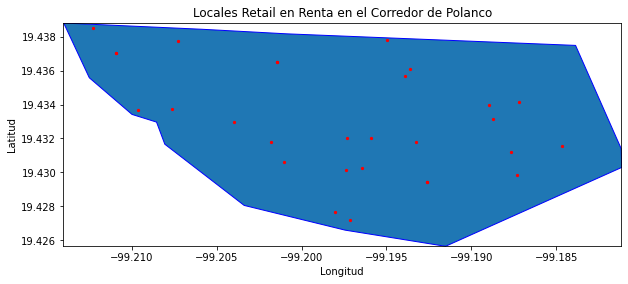

In [21]:
# Se carga un mapa base de México
mexico = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mexico = mexico[mexico['name'] == 'Mexico']

# Se carga el polígono de Polanco
polanco_geo = gpd.read_file('Corredor_Polanco.geojson')

# Se crea la figura y el eje
fig, ax = plt.subplots(figsize=(10, 10))

# Se dibuja el mapa base
mexico.plot(ax=ax, color='white', edgecolor='black')

# Se ibuja los límites de Polanco
polanco_geo.plot(ax=ax, edgecolor='blue')

# Se dibujan los locales en Polanco
espacios_en_polanco.plot(ax=ax, marker='o', color='red', markersize=5)

# Se ajustan los límites del eje para que se enfoque Polanco
x_min, y_min, x_max, y_max = polanco_geo.total_bounds
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Se añade título y etiquetas
plt.title('Locales Retail en Renta en el Corredor de Polanco')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.show()

Más interesante sería mostrar los locales de manera que el precio de la renta determine su tamaño.

/tmp/ipykernel_162257/2914630151.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  mexico = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


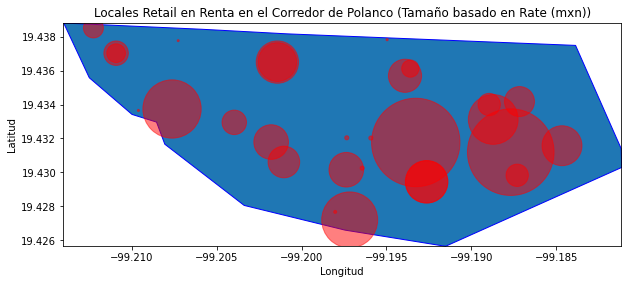

In [22]:
# Se carga un mapa base de México
mexico = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mexico = mexico[mexico['name'] == 'Mexico']

# Se carga el polígono de Polanco
polanco_geo = gpd.read_file('Corredor_Polanco.geojson')

# Se crea la figura y el eje
fig, ax = plt.subplots(figsize=(10, 10))

# Se dibuja el mapa base
mexico.plot(ax=ax, color='white', edgecolor='black')

# Se ibuja los límites de Polanco
polanco_geo.plot(ax=ax, edgecolor='blue')

# Se dibujan los locales en Polanco con el tamaño de los puntos basado en su valor de rate_mxn.
factor_de_ajuste = 100  # Para escalar los valores
espacios_en_polanco.plot(ax=ax, marker='o', color='red', markersize=espacios_en_polanco['rate_mxn'] / factor_de_ajuste, alpha=0.5)

# Se dibujan los locales en Polanco
x_min, y_min, x_max, y_max = polanco_geo.total_bounds
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Se añade título y etiquetas
plt.title('Locales Retail en Renta en el Corredor de Polanco (Tamaño basado en Rate (mxn))')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.show()

Esta manera de graficar mapas en python está obsoleta, pero todavía funciona.

### Respuestas a preguntas

Los espacios individuales contemplan a los subespacios y a los espacios con `parent_id="0"` "...Espacios “sub” (subespacios): son espacios individuales..." (escribo la cita para que no haya duda al respecto). Luego, como la variable `is_complex` no tiene valores faltantes, necesariamente esta tendría que valer `"0"` independientemente de que `is_complex` esté o no. Voy a trabajar con la `data2` que tienen asignado algún valor, pero que pueden presentar datos atípicos.

In [23]:
#espacios_individuales = data[(data['parent_id'].isnull()) & (data['is_complex'] == 0)]
espacios_individuales = data2[data2['is_complex'] == 0].copy()
subespacios = data2[(data2['parent_id'].notnull()) & (data2['is_complex'] == 0)]
espacios_multi_tenant = data[data['is_complex'] == 1]

num_espacios_individuales = len(espacios_individuales)
num_subespacios = len(subespacios)
num_espacios_multi_tenant = len(espacios_multi_tenant)

print(f"Existen {num_espacios_individuales} espacios individuales.")
print(f"Existen {num_subespacios} subespacios.")
print(f"Existen {num_espacios_multi_tenant} multi-tenant.")

Existen 3764 espacios individuales.
Existen 1963 subespacios.
Existen 787 multi-tenant.


La siguiente tabla muestra el número de espacios por tipo de Spot para los espacios individuales. Se ha incluido el número de espacios sin tipo de Spot.

In [24]:
espacios_por_tipo = espacios_individuales.groupby('spot_type_id').size()
print(espacios_por_tipo)

spot_type_id
11           468
13           810
15           328
9            423
faltante    1735
dtype: int64


In [25]:
espacios_individuales['created_at'] = pd.to_datetime(espacios_individuales['created_at'])
espacios_individuales['trimestre'] = espacios_individuales['created_at'].dt.to_period('Q')
trimestre_mas_espacios = espacios_individuales.groupby('trimestre').size().idxmax()

/tmp/ipykernel_162257/884704809.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  espacios_individuales['trimestre'] = espacios_individuales['created_at'].dt.to_period('Q')


In [26]:
print(trimestre_mas_espacios)

2023Q3


Se crearon más espacios individuales en el tercer trimestre del año 2023.

In [27]:
tipo_spot_mas_metros = espacios_individuales.groupby('spot_type_id')['square_space'].sum().idxmax()

print(f"El tipo de Spot que suma más metros cuadrados es: {tipo_spot_mas_metros}.")

El tipo de Spot que suma más metros cuadrados es: 15.


Es decir, los terrenos, lo cual parece ser el resultado esperado.

Si tuviera más tiempo habría realizado un análisis exploratorio más amplio y habría investigado una mejor manera de presentar los mapas. Especialmente, habría usado técnicas de análisis multivariaado para obtener indicadores útiles y detectar los atípicos que mencioné más arriba. Estoy pensando en que habría sido interesante un PCA (análisis de componentes principales por sus siglas en inglés). También podría ser pertinente hacer inferencia o predicciones empleando técnicas de machine learning entre otras. 

Por otra parte, me hubiera gustado realizar un informe en condiciones, no sólo un reporte en un notebook. Estoy pensando en un documento pdf similar al obtenido en R-Markdown junto a un Dashboard interactivo en Power BI o Looker Data Studio. Esto último con el foco en la facilidad de uso para el personal no técnico como mi potencial jefa Monica.